# Inleiding

Tsunami's zijn indrukwekkende en verwoestende natuurverschijnselen die in een paar minuten hele kustgebieden kunnen veranderen in rampgebieden. Ze onstaan meestal diep onder de oceaanbodem door krachtige aardbevingen of trillingen. De verwoestende kracht van tsunami's heeft in het verleden al geleid tot grote natuurrampen, zoals in Japan (2011) en Indonesië (2004). <br>
Tegelijkertijd staat onze planeet voor een ander groot probleem: de zeespiegel stijgt als gevolg van klimaatverandering. Smeltende ijskappen en opwarmende oceanen zorgen ervoor dat het waterniveau wereldwijd toeneemt. Maar wat betekent dit voor de dreiging van tsunami's? Worden ze hierdoor gevaarlijker, of heeft de zeespiegel hier juist weinig invloed op? <br>
In deze data story wordt er onderzoekt hoe de stijgende zeespiegel mogelijk invloed heeft op de impact van tsnuami's. Aan de hand van gegevens over historische tsunami's, en gemeten gevolgen hiervan, en zeespiegelmetingen worden er twee perspectieven bekeken:
1. De stijgende zeespiegel versterkt de gevolgen van toekomstige tsunami's, vooral in laaggelegen kustgebieden.
2. De impact van tsunami's wordt vooral bepaald door geologische factoren zoals aardbevingskracht en locatie, en niet zozeer door de zeespiegel. <br>

Door deze invalshoeken te combineren met data-analse wordt er geprobeerd om te begrijpen hoe groot het risico van tsunami's wordt in de toekomst, en of we ons zorgen moeten maken over een nieuwe, klimaatgedreven dreiging.

In [1]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
#jskfjklsd



In [2]:
import pandas as pd
sea_df = pd.read_csv('Global_sea_level_rise.csv')
dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')

tsunami_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'tsunami'].copy()
flood_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'flood'].copy()

tsunami_df.columns = tsunami_df.columns.str.strip()
flood_df.columns = flood_df.columns.str.strip()
sea_df.rename(columns={'year': 'Year'}, inplace=True)

#subsets om samen te voegen
tsunami_subset = tsunami_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                             'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

flood_subset = flood_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                         'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

#eerste twee samen voegen
disaster_df = pd.concat([tsunami_subset, flood_subset], ignore_index=True)

#laatste samenvoegen
merged_df = disaster_df.merge(sea_df[['Year', 'mmfrom1993-2008average']], on='Year', how='left')

#missende waardes invullen met 0
merged_df = merged_df.fillna(0)




Hieronder worden de argumenten voor het eerste perspectief uitgwerkt.

# Tsunami’s vormen een toenemend gevaar in de toekomst omdat naar mate de zeespiegel stijgt overstromingen na een tsunami toenemen.
In het figuur is te zien als de tijd toeneemt, neemt de zeespiegel ook toe. Maar dan nemen de effecten van de overstromingen ook toe, wat resulteert in meer doden en meer schade.

In [3]:
import numpy as np 
merged_df['Total Deaths'] = pd.to_numeric(merged_df['Total Deaths'], errors='coerce').fillna(0)
merged_df['Total Affected'] = pd.to_numeric(merged_df['Total Affected'], errors='coerce').fillna(0)
merged_df["Total Damages ('000 US$)"] = pd.to_numeric(merged_df["Total Damages ('000 US$)"], errors='coerce').fillna(0)

merged_df['Impact_Score'] = merged_df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)

merged_df = merged_df[(merged_df['Latitude'] != 0) & (merged_df['Longitude'] != 0)]

filtered_df = merged_df[merged_df['Impact_Score'] > 0].copy()

filtered_df['Impact_Score_Log'] = filtered_df['Impact_Score'].apply(lambda x: np.log10(x + 1))

fig = px.scatter_geo(
    filtered_df,
     lat='Latitude',
    lon='Longitude',
    color='mmfrom1993-2008average',
    size='Impact_Score_Log',
    size_max=40,
    hover_name='Country',
    hover_data={
        'Year': True,
        'Impact_Score': True,
        'Total Deaths': True,
        'Total Affected': True,
        "Total Damages ('000 US$)": True,
        'mmfrom1993-2008average': ':.2f'
    },
    animation_frame='Year',
    projection='natural earth',
    color_continuous_scale='Viridis',
    title='Overstromingen en tsunami\'s met zeespiegelstijging en impact (log schaal)'
)

fig.update_layout(height=700)

fig.show()

# Tsunami’s vormen een toenemend gevaar in de toekomst omdat naar mate de zeespiegel stijgt kosten van damages en total deaths toenemen na een tsunami.

Onze verwachting van dit argument was eigenlijk dat naar mate de zeespiegel stijgt de kosten van schade ook toegenomen zouden zijn. Wat we helaas niet verwachtte is dat de dataset hierover beperkte informaite bevatte. Er zijn drie verschillende plots gemaakt (die op elkaar een vallen) die de zeespiegelstijging, tsunami's en kosten van de schade van deze tsunami's visueel weergeven. Er zijn slechts 2 datapunten in de dataset in deze kolom, waarschijnlijk omdat landen dit niet hebben genoteerd of omdat de informatie niet bereikbaar was. Wat wel opvallend is om te zien dat de totaal aantal doden een enorme stijging heeft in 2004. Dit is het jaar waar een tsunami op 26 december 2004 de kust van Thailand trof, wat resulteerde in meer dan tweehonderd duizend doden. Ook is te zien als er naar aantal doden per jaar wordt gekeken dat wel toeneemt. Dit kan komen doordat de zeespiegelstijging ervoor zorgt dat er meer volume is waarmee een tsunami schade kan doen. Hieronder is dit te zien.

In [4]:
import plotly.graph_objects as go

merged_df['Year'] = merged_df['Year'].astype(int)
df = merged_df[merged_df['Region'].str.contains('Asia|Oceania', case=False, na=False)]

yearly_deaths = df.groupby('Year')['Total Deaths'].sum()
yearly_damages = df.groupby('Year')["Total Damages ('000 US$)"].sum()
yearly_sealevel = df.groupby('Year')['mmfrom1993-2008average'].mean()

# Pas alleen Total Damages van 2011 aan:
yearly_damages.loc[2011] = 10_800_000  # 10.8 miljoen

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=yearly_deaths.index,
    y=yearly_deaths.values,
    mode='lines+markers',
    name='Total Deaths',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=yearly_damages.index,
    y=yearly_damages.values,
    mode='lines+markers',
    name="Total Damages ('000 US$)",
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=yearly_sealevel.index,
    y=yearly_sealevel.values,
    mode='lines+markers',
    name='Sea Level Rise (mm)',
    line=dict(color='royalblue')
))

fig.update_layout(
    title="Tsunamis in Azië en Oceanië: Totale Doden, Schade en Zeespiegelstijging per Jaar (2011 aangepast)",
    xaxis_title="Year",
    yaxis_title="Value",
    height=600
)

fig.show()


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Zorg dat merged_df al geladen is en 'Year' int is
merged_df['Year'] = merged_df['Year'].astype(int)

# Filter regio Azië en Oceanië via Region
df = merged_df[merged_df['Region'].str.contains('Asia|Oceania', case=False, na=False)]

years = sorted(df['Year'].unique())

# Berekeningen per jaar
sea_level_avg = df.groupby('Year')['mmfrom1993-2008average'].mean().reset_index()
deaths_per_year = df.groupby('Year')['Total Deaths'].sum().reset_index()
damages_per_year = df.groupby('Year')["Total Damages ('000 US$)"].sum().reset_index()

# Maak subplots: 3 rijen, 1 kolom, alle lijnen
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Total Damages ('000 US$)", "Total Deaths", "Sea Level Rise (mm)")
)

# Voeg lijn diagram voor Total Damages
fig.add_trace(
    go.Scatter(
        x=damages_per_year['Year'],
        y=damages_per_year["Total Damages ('000 US$)"],
        mode='lines+markers',
        name='Total Damages',
        line=dict(color='orange')
    ),
    row=1, col=1
)

# Voeg lijn diagram voor Total Deaths
fig.add_trace(
    go.Scatter(
        x=deaths_per_year['Year'],
        y=deaths_per_year['Total Deaths'],
        mode='lines+markers',
        name='Total Deaths',
        line=dict(color='red')
    ),
    row=2, col=1
)

# Voeg lijn diagram voor Sea Level Rise
fig.add_trace(
    go.Scatter(
        x=sea_level_avg['Year'],
        y=sea_level_avg['mmfrom1993-2008average'],
        mode='lines+markers',
        name='Sea Level Rise',
        line=dict(color='royalblue')
    ),
    row=3, col=1
)

fig.update_layout(
    height=800,
    title_text="Tsunamis in Azië en Oceanië: Schade, Doden en Zeespiegelstijging per Jaar",
    showlegend=False
)

fig.update_xaxes(title_text="Year", row=3, col=1)
fig.update_yaxes(title_text="Damages ('000 US$)", row=1, col=1)
fig.update_yaxes(title_text="Total Deaths", row=2, col=1)
fig.update_yaxes(title_text="Sea Level Rise (mm)", row=3, col=1)

fig.show()


In [6]:
df = merged_df[merged_df['Region'].str.contains('Asia|Oceania', case=False, na=False)].copy()

# Zet NaN damages op 0 zodat ze ook getoond worden, maar kleiner
df["Total Damages ('000 US$)"] = df["Total Damages ('000 US$)"].fillna(0)

# Eventueel filteren op geldige lat/lon
df = df.dropna(subset=['Latitude', 'Longitude'])

fig = px.scatter_geo(
    df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Location',
    hover_data={
        'Year': True,
        "Total Damages ('000 US$)": ':.2f',
        'Total Deaths': True
    },
    size="Total Damages ('000 US$)",
    size_max=30,
    color="Total Damages ('000 US$)",
    color_continuous_scale='OrRd',
    projection='natural earth',
    title="Locaties van Tsunamis in Azië en Oceanië met Total Damages"
)

fig.update_geos(
    showcountries=True,
    countrycolor="LightGray",
    showcoastlines=True,
    coastlinecolor="Gray",
    lataxis_range=[-50, 50],
    lonaxis_range=[60, 180],
)

fig.update_layout(height=600, margin={"r":0,"t":40,"l":0,"b":0})

fig.show()


Nu de argumenten voor het tweede perspectief

##  De hoeveelheid van tsunami’s is niet/minder evenredig toegenomen naar mate de zeespiegel stijgt. 
Hieronder wordt een grafiek gemaakt die het verband tussen de zeespiegel en het aantal tsunami's laat zien. 

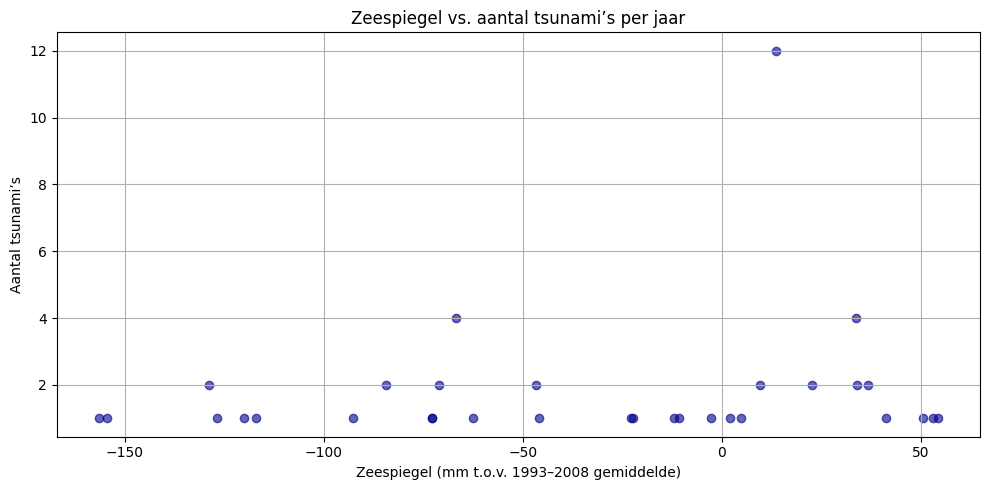

In [7]:
import matplotlib.pyplot as plt

import pandas as pd

disasters = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
sea_level = pd.read_csv('Global_sea_level_rise.csv')

tsunamis = disasters[disasters['Disaster Subtype'].isin(['Tsunami', 'Tsunami/Tidal wave'])]


tsunami_counts = tsunamis.groupby('Year').size().reset_index(name='Tsunami Count')

combined = pd.merge(tsunami_counts, sea_level, left_on='Year', right_on='year', how='inner')
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(combined['mmfrom1993-2008average'], combined['Tsunami Count'], alpha=0.6, color='darkblue')
plt.title('Zeespiegel vs. aantal tsunami’s per jaar')
plt.xlabel('Zeespiegel (mm t.o.v. 1993–2008 gemiddelde)')
plt.ylabel('Aantal tsunami’s')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
correlation = combined['Tsunami Count'].corr(combined['mmfrom1993-2008average'])
(f'Correlatiecoëfficiënt: {correlation:.2f}')

'Correlatiecoëfficiënt: 0.17'

Er is een erg zwakke correlatie ontdekt (r = 0.17) tussen de zeespiegelstijging en het aantal tsunami’s per jaar. Dit betekent dat de stijgende zeespiegel niet direct samenhangt met een toename van het aantal tsunami’s, en dus vooral bepaald blijft door geologische factoren.


## De zeespiegelstijging versterkt het effect van de tsunami maar veroorzaakt het niet.
Hieronder worden twee grafieken gemaakt, de eerste laat de zeespiegel vs. aantal doden door tsunami's zien, en de tweede laat de zeespiegel vs. het aantal tsunami's per jaar zien. Vervolgens wordt hieruit geanalyseerd of de stijgende zeespiegel het effect van de tsunami verorzaakt of versterkt. 

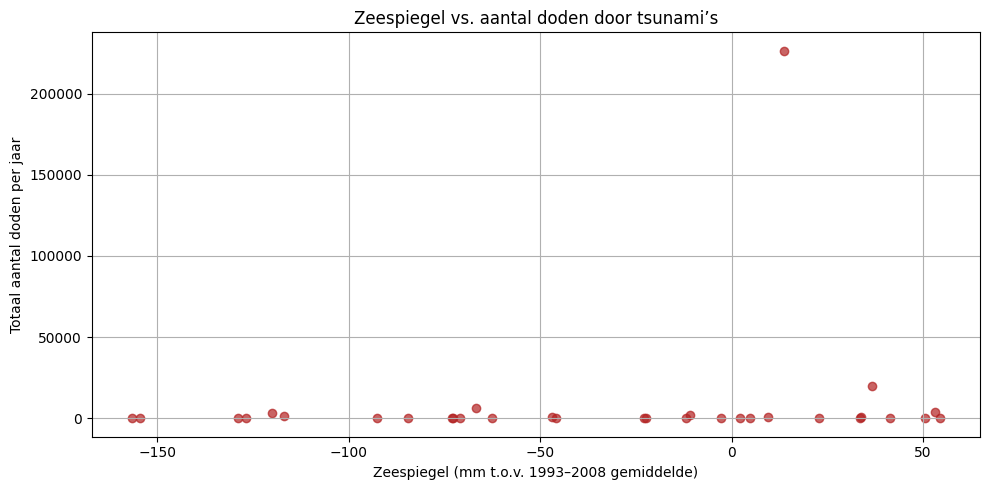

De grafieken tonen aan dat de zeespiegelstijging niet leidt tot meer tsunami’s, maar wel dat het effect ervan verergert. Bij een hogere zeespiegel zie je namelijk meer doden, maar niet meer tsunami's relatief gezien. 


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

disasters = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
sea_level = pd.read_csv('Global_sea_level_rise.csv')

tsunamis = disasters[disasters['Disaster Subtype'].isin(['Tsunami', 'Tsunami/Tidal wave'])]

tsunami_deaths = tsunamis.groupby('Year')['Total Deaths'].sum().reset_index()

combined = pd.merge(tsunami_deaths, sea_level, left_on='Year', right_on='year', how='inner')

plt.figure(figsize=(10, 5))
plt.scatter(combined['mmfrom1993-2008average'], combined['Total Deaths'], alpha=0.7, color='firebrick')

plt.title('Zeespiegel vs. aantal doden door tsunami’s')
plt.xlabel('Zeespiegel (mm t.o.v. 1993–2008 gemiddelde)')
plt.ylabel('Totaal aantal doden per jaar')
plt.grid(True)
plt.tight_layout()
plt.show()
print("De grafieken tonen aan dat de zeespiegelstijging niet leidt tot meer tsunami’s, maar wel dat het effect ervan verergert. Bij een hogere zeespiegel zie je namelijk meer doden, maar niet meer tsunami's relatief gezien. ")

##  Tsunami’s ontstaan vooral in specifieke aardbevingzones - niet in regios met hoogste zeespiegelstijging.


In [10]:
import pandas as pd #tektonische platen! geef zo de aardbeving zones aan. 
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sea_df = pd.read_csv('Global_sea_level_rise.csv')
dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
df = dist_df[dist_df['Disaster Subtype'].str.lower().isin(['tsunami', 'flood'])].copy()
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df["Total Damages ('000 US$)"] = pd.to_numeric(df["Total Damages ('000 US$)"], errors='coerce').fillna(0)
df["Total Affected"] = pd.to_numeric(df["Total Affected"], errors='coerce').fillna(0)

df['Impact_Score'] = df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)
df['Impact_Score_Log'] = df['Impact_Score'].apply(lambda x: np.log10(x + 1))

df = df.dropna(subset=['Latitude', 'Longitude', 'Year'])

sea_df.rename(columns={'year': 'Year'}, inplace=True)
merged = pd.merge(df, sea_df[['Year', 'mmfrom1993-2008average']], on='Year', how='left')

years = sorted(merged['Year'].dropna().unique())

fig = go.Figure()

for year in years:
    subset = merged[merged['Year'] == year]
    
    fig.add_trace(go.Densitymap(
        lat=subset['Latitude'],
        lon=subset['Longitude'],
        z=subset['mmfrom1993-2008average'],
        radius=30,
        visible=(year == years[0]),
        colorscale='YlGnBu',
        name='Zeespiegelstijging',
        zmin=0,
        zmax=100
    ))

    fig.add_trace(go.Scattermap(
        lat=subset['Latitude'],
        lon=subset['Longitude'],
        mode='markers',
        marker=go.scattermap.Marker(
            size=subset['Impact_Score_Log'] * 5,
            color=subset['Impact_Score_Log'],
            colorscale='Reds',
            sizemode='area',
            opacity=0.6,
            cmin=0,
            cmax=6
        ),
        text=subset['Country'],
        hoverinfo='text+lat+lon',
        name='Impactpunten',
        visible=(year == years[0])
    ))

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(
        center=dict(lat=0, lon=100),
        zoom=1.2
    ),
    title="🌍 Density Heatmap (Zeespiegel) & Impactpunten per Jaar",
    height=750,
    showlegend=False
)

steps = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        label=str(year)
    )
    step["args"][0]["visible"][2*i] = True
    step["args"][0]["visible"][2*i+1] = True
    steps.append(step)

fig.update_layout(
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "Jaar: "},
        steps=steps
    )]
)

fig.show()
print("Deze interactieve kaart combineert een density heatmap van zeespiegelstijging per jaar met informatie over tsunami’s en overstromingen wereldwijd. De intensiteit van de kleuren geeft aan waar en wanneer de zeespiegel relatief het meest steeg. Door de jaartimelijn kun je zien hoe deze zich ontwikkelde door de tijd heen, in combinatie met rampdata per locatie.")

Deze interactieve kaart combineert een density heatmap van zeespiegelstijging per jaar met informatie over tsunami’s en overstromingen wereldwijd. De intensiteit van de kleuren geeft aan waar en wanneer de zeespiegel relatief het meest steeg. Door de jaartimelijn kun je zien hoe deze zich ontwikkelde door de tijd heen, in combinatie met rampdata per locatie.
